In [2]:
#import library

import numpy as np 
import pandas as pd 
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
%matplotlib inline

In [7]:
#===Get Data====

#Get train data
df_train = pd.read_csv('../data/given_data/train.csv')

#Get test data
df_test= pd.read_csv("../data/given_data/test.csv")

In [3]:
#===Processing===

#Create stopword List
stops = set(stopwords.words("english"))

In [4]:
#===word_match_share===

#Calculate Jaccard　coefficient between two questions with word count.
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [5]:
#Apply df_train data to word_match_function
word_match_train = df_train.apply(word_match_share, axis=1, raw=True)

Text(0.5,0,'word_match_share')

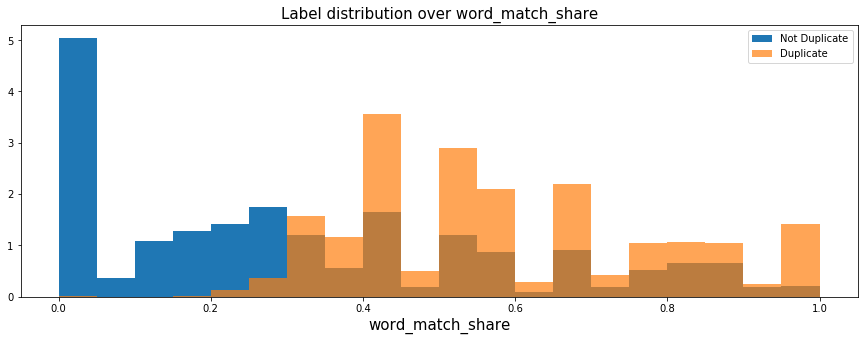

In [7]:
#Display the output of word_match_count function
#y-axis:the number of similarity
#x-axis:similarity

plt.figure(figsize=(15, 5))
plt.hist(word_match_train[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(word_match_train[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [8]:
#===tfidf_word_match_share====

#Create word list
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

#Calculate weight
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [9]:
#Calculate Jaccard　coefficient between two questions with tfidf word count.
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

In [10]:
#Apply df_train data to word_match_function
tfidf_word_match_train = df_train.apply(tfidf_word_match_share, axis=1, raw=True)

/Users/tanakasho/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,0,'word_match_share')

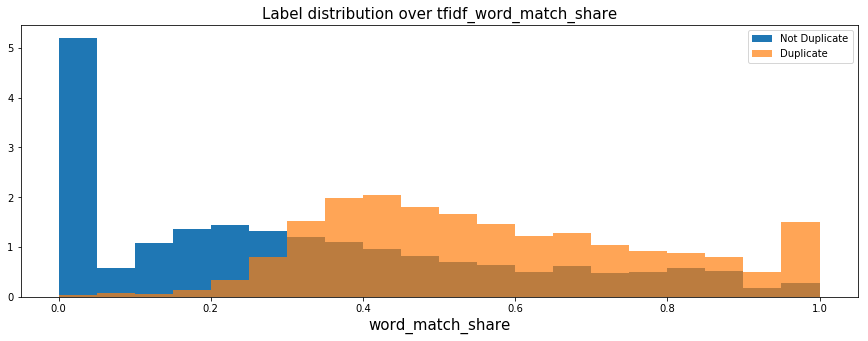

In [12]:
#Display the output of tfidf_word_match_count function
#y-axis:the number of similarity
#x-axis:similarity
plt.figure(figsize=(15, 5))
plt.hist(tfidf_word_match_train[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_word_match_train[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [13]:
#===word_count_distance===

#Count word_count_distance
def word_count_distance(row):
    count_word = len(str(row["question1"]).lower().split()) - len(str(row["question2"]).lower().split())
    return np.linalg.norm(count_word)

In [ ]:
#Apply df_train data to word_match function
word_count_distance_train = df_train.apply(word_count_distance, axis=1, raw=True)

In [17]:
#===Calculate AUC===
print('word_match_train AUC :', roc_auc_score(df_train['is_duplicate'], word_match_train))
print('tfidf_word_match_train AUC :', roc_auc_score(df_train['is_duplicate'], tfidf_word_match_train.fillna(0)))

word_match_train AUC : 0.780553200628
tfidf_word_match_train AUC : 0.77056466105


In [22]:
#Initialize train dataframe
x_train = pd.DataFrame()
y_train = pd.DataFrame()

#Add the column of  predictor valiable(explained valiable)
x_train["word_match"] = word_match_train
x_train["tfidf_word_match"] = tfidf_word_match_train
x_train["word_count_distance"] = word_count_distance_train

#Add the column of objective valiable
y_train["is_duplicate"] = df_train.is_duplicate

In [42]:
#Save x_train
x_train.to_csv("data/train_data/x_train.csv",index = False)

#Save y_train
y_train.to_csv("data/train_data/y_train.csv",index = False)

In [29]:
#Create modle(RandomForest)
random_forest_model= RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=100, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, bootstrap=True, oob_score=True, n_jobs=1, random_state=1, verbose=0, warm_start=False, class_weight=None)

In [31]:
#Learn model
#If the value of x_train is nan,it replaces zero.
random_forest_model.fit(x_train.fillna(0),y_train)

/Users/tanakasho/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [9]:
#Save model 
joblib.dump(random_forest_model, '../model/random_forest_model.pkl.cmp', compress=True)

['../model/random_forest_model.pkl.cmp']

In [10]:
#Load model
random_forest_model = joblib.load('../model/random_forest_model.pkl.cmp')

In [32]:
#===test data====

#Apply df_test data to word_match_share function
word_match_test= df_test.apply(word_match_share, axis=1, raw=True)

#Apply df_test data to tfidf_word_match_share function
tfidf_word_match_test = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

#Apply df_test data to word_count_distance function
word_count_distance_test= df_test.apply(word_count_distance, axis=1, raw=True)

/Users/tanakasho/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/tanakasho/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [33]:
#Initialize test dataframe
x_test = pd.DataFrame()
y_test = pd.DataFrame()

#Add the column of  predictor valiable(explained valiable)
x_test["word_match"] = word_match_test
x_test["tfidf_word_match"] = tfidf_word_match_test
x_test["word_count_distance"] = word_count_distance_test

In [43]:
#Save x_test
x_test.to_csv("../data/test_data/x_test.csv",index = False)

In [12]:
#Load x_test(from the second time)
x_test = pd.read_csv("../data/test_data/x_test.csv")

In [14]:
#Predict y_text
y_test=random_forest_model.predict_proba(x_test.fillna(0))

In [17]:
#Initialize submission DataFrame
submission=pd.DataFrame()

#Add the column of test_id
submission['test_id']=df_test['test_id']

#Add the column of 0-class probablity
submission['is_duplicate']=y_test[:,1]

#Save submission
submission.to_csv("../submission/submission1.csv", index=False)

In [15]:
y_test

array([[ 0.93341352,  0.06658648],
       [ 0.36421634,  0.63578366],
       [ 0.3862067 ,  0.6137933 ],
       ..., 
       [ 0.99670041,  0.00329959],
       [ 0.50157748,  0.49842252],
       [ 0.47511209,  0.52488791]])

In [18]:
len(y_test)

2345796